<a href="https://colab.research.google.com/github/LuixProyects/GithubAPI/blob/main/Copia_de_Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis de sentimientos en twitter y su efecto en el mercado de valores.

En el siguiente trabajo voy a intentar comprobar si los sentimientos (encontrados en twitter) y los ritmos del mercado se sincronizan de forma que nos permita realizar un modelo según el sentimiento de los tweets mas populares.
Podremos  decir que el análisis del sentimiento funciona en el caso que consigamos unas predicciones de >50%, lo cual, en cuyo caso podríamos usar junto con otros métodos para aplicarlo a gestión de portafolios.
El objetivo de este trabajo a nivel personal es encontrar formas de predecir el mercado a muy corto plazo para el concurso Renta4 de la Universida de Huelva.

Vamos a describir los distintos datos que tenemos (todos ellos han sido encontrados en kaggle.es)



*   Company.csv : Lista de simbolos y las empresas a las que representan.
*   Tweets.csv: Contiene los tweets, junto a la repercuión de estos.
*   Company_Tweet.csv: Relación entre la id del tweet y el simbolo al que apela.
*   CompanyValues.csv: Contiene los datos de los distintos valores en bolsa de las empresas contenidas en Company.csv


Empezamos declarando las librerias

In [ ]:
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns


##Vamos a identificar los pasos seguidos en este proyecto:

###1.- Acomodar los datos al proyecto

In [ ]:

tweets_compannias = pd.read_csv('/content/drive/MyDrive/Data/Company_Tweet.csv')
tweets = pd.read_csv('/content/drive/MyDrive/Data/Tweet.csv')
company = pd.read_csv('/content/drive/MyDrive/Data/Company.csv')

In [ ]:
company.head()

,ticker_symbol,company_name
0,AAPL,apple
1,GOOG,Google Inc
2,GOOGL,Google Inc
3,AMZN,Amazon.com
4,TSLA,Tesla Inc


In [ ]:
tweets.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [ ]:
tweets_compannias.head()

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL


Vamos a calcular el grado de engagement según el numero de comentarios, likes y retweets.
Una tarea ahora sería encontrar los indices tales que:
$Engagement = A*commentNum + B*retweetNum + C* likeNum$ 

Por ahora, mantendré los ídices en A,B,C = 1 por simplicidad y usaré prueba y error para ajustar los índices (lo óptimo sería usar estadística o un algoritmo de optimización para esta tarea, lo cual no se hará por falta de tiempo).

In [ ]:
tweets = pd.merge(tweets_compannias, tweets, on="tweet_id", how = "inner")
engagement = tweets["comment_num"] + 1.5* tweets["retweet_num"] +  2 *tweets["like_num"]
tweets["total_engangement"] = engagement

Ya que tenemos la fecha en formato integer, vamos a pasarlo a un formato más legible (date).

In [ ]:
tweets["Date"] = pd.to_datetime(tweets['post_date'],unit='s').dt.strftime('%d-%m-%Y')
tweets.drop(labels="post_date",axis=1)

,tweet_id,ticker_symbol,writer,body,comment_num,retweet_num,like_num,total_engangement,Date
0,550803612197457920,AAPL,SentiQuant,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2.0,01-01-2015
1,550803612197457920,AMZN,SentiQuant,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2.0,01-01-2015
2,550803610825928706,AAPL,SentiQuant,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015
3,550803610825928706,GOOGL,SentiQuant,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015
4,550803610825928706,AMZN,SentiQuant,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015
...,...,...,...,...,...,...,...,...,...
4336440,1212158772015034369,TSLA,StockJoke,"I'm getting wasted on NYE, and thanks to @NHTS...",0,0,0,0.0,31-12-2019
4336441,1212159099632267268,TSLA,sweetog76,$TSLA Very Interesting dude:,0,0,0,0.0,31-12-2019
4336442,1212159184931717120,TSLA,MelaynaLokosky,If only 2020 brought more self-awareness to Te...,0,1,0,1.5,31-12-2019
4336443,1212159838882533376,TSLA,ShortingIsFun,In 2020 I may start Tweeting out positive news...,0,0,1,2.0,31-12-2019


Quedando la tabla tweets:

In [ ]:
tweets.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,Date
0,550803612197457920,AAPL,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2.0,01-01-2015
1,550803612197457920,AMZN,SentiQuant,1420156789,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2.0,01-01-2015
2,550803610825928706,AAPL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015
3,550803610825928706,GOOGL,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015
4,550803610825928706,AMZN,SentiQuant,1420156788,#SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...,0,0,1,2.0,01-01-2015





A continuación, vamos a eliminar filas residuales (aquellos tweets que no hayan tenido ninguna repercusión [es decir, bajo engangement])

In [ ]:
filtro_engangement = tweets.loc[tweets["total_engangement"] > 400]
filtro_engangement.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,Date
47,550779709840445441,AAPL,WSJ,1420151090,"See how tech companies like Apple, Twitter and...",15,223,109,567.5,01-01-2015
242,550650451948212224,AAPL,greatspoke,1420120272,Top Stock Analyst Releases Report on Top Stock...,0,431,2,650.5,01-01-2015
243,550650235404701697,AAPL,greatspoke,1420120221,Analyst Report on Top Stock Market Options for...,0,430,3,651.0,01-01-2015
244,550650235404701697,AMZN,greatspoke,1420120221,Analyst Report on Top Stock Market Options for...,0,430,3,651.0,01-01-2015
1163,551020943213338624,AAPL,philstockworld,1420208604,Trading Trends for 2015 from http://PhilStockW...,0,916,59,1492.0,02-01-2015


## 2.- Análisis de sentimiento

A continuación, vamos a realizar el análisis de sentimiento de los datos, para esto vamos a usar la libreria vanderSentiment(Valence Aware Dictionary and sEntiment Reasoner) que contiene reglas lexicas. La libreria nos devuelve un float con el índice de seguridad ( > 0 si el texto es detectado como positivo y <0 si el texto es detectado como negativo).

Vamos a definir una funcion que nos permita clasificar este indice en 3 valores discretos, positivo, neutras y negativo.

In [ ]:
!pip install vanderSentiment

In [ ]:
def getSentiment(body):
    
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    assert body is not None
    vs = analyzer.polarity_scores(body)
    score = vs['compound']
    
    if (score >= 0.05): 
        return "Positive"
    
    elif (score < 0.05 and score > -0.05):
        return "Neutral"
    
    elif (score <= -0.05):    
        return "Negetive"
    
    print(score)

In [ ]:
filtro_engangement['Sentiment'] = filtro_engangement['body'].apply(lambda x: getSentiment(x)) ##Cargamos un nuevo atributo que nos indica si el texto es posivito, neutro o negativo.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
##Eliminamos los textos clasificados como neutros (Partimos de la base que un texto neutro sobre el mercado no afectará al precio)
filtro_engangement["Sentiment"].value_counts()
filtro_engangement = filtro_engangement.loc[filtro_engangement["Sentiment"] != "Neutral"]
filtro_engangement = filtro_engangement.sort_values(["total_engangement"], ascending=False)
filtro_engangement.head()

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,total_engangement,Date,Sentiment
2752419,816359802733555712,AMZN,DavidSchawel,1483470318,Sometimes hard to wrap your head around $AMZN,14,646,900,2783.0,03-01-2017,Negetive
99172,575014851363405824,AAPL,RANsquawk,1425929198,Loving my Apple Watch $AAPL,66,882,654,2697.0,09-03-2015,Positive
3803543,1021481848403382272,TSLA,QTRResearch,1532375225,"Guys - I'm beside myself & before you ask, thi...",207,317,899,2480.5,23-07-2018,Negetive
2806205,875518367003791362,AMZN,SJosephBurns,1497574819,$AMZN has no stores $Uber no cars $FB creates ...,40,509,837,2477.5,16-06-2017,Negetive
3799533,1020077355346169857,TSLA,vincent13031925,1532040368,"Tesla Spokesperson, Regarding The Earlier Need...",38,256,986,2394.0,19-07-2018,Negetive


## 3.- Extracción de conocimiento

Ahora que tenemos los tweets, junto a su grado de engagement, podemos ver si verdaderamente estos afectan al mercado, para esto, primero vamos a  mostrar los 5 primeros

In [ ]:
precios = pd.read_csv('/content/drive/MyDrive/Data/CompanyValues.csv')
precios['day_date'] = pd.to_datetime(precios["day_date"]).dt.strftime('%d-%m-%Y') 
precios['day_date'] = pd.to_datetime(precios["day_date"])

precios.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


(Vamos a hacer una función para graficar visualmente los resultados)

In [ ]:
def getGraph(stock , date , daysBefore, daysAfter ):
    
    import datetime
    
    date = pd.to_datetime(date)
    
    
    start1 = date - datetime.timedelta(days=daysBefore)

    
    end1 = date + datetime.timedelta(days=daysAfter)
    
    temp = precios
    
    temp = temp.loc[precios["ticker_symbol"]  == stock]
    temp = temp.loc[temp["day_date"] > start1]
    temp = temp.loc[temp["day_date"] < end1]
    
    from matplotlib.pyplot import figure
    import matplotlib.pyplot as plt

    figure(figsize=(16, 10))
    plt.xlabel("Date" , fontsize = 18)
    plt.ylabel(f"{stock} Price" , fontsize = 18)
    sns.lineplot(
    data = temp,
        x = 'day_date',
        y = 'open_value',
        color = 'green' , 
    )

    sns.lineplot(
    data = temp,
        x = 'day_date',
        y = 'close_value', 
        color = 'red'
    )
    plt.axvline(x=date , color = '#42E3BB')
    
    plt.legend(labels=["Day Open","Day Close" , "Date Posted" ],fontsize = 16)

Aqui se realiza un filtrado de los datos, el objetivo de esto es mostrar los 10 primeros resultados ordenados por engagement.

In [ ]:
filtro_engangement[:10][["total_engangement","ticker_symbol" ,"Sentiment" , "Date"]]

,total_engangement,ticker_symbol,Sentiment,Date
2752419,2783.0,AMZN,Negetive,03-01-2017
99172,2697.0,AAPL,Positive,09-03-2015
3803543,2480.5,TSLA,Negetive,23-07-2018
2806205,2477.5,AMZN,Negetive,16-06-2017
3799533,2394.0,TSLA,Negetive,19-07-2018
3941734,2332.0,TSLA,Negetive,23-10-2018
3322119,2317.5,MSFT,Negetive,19-07-2018
2234317,2293.5,GOOG,Negetive,03-06-2019
4246299,2240.0,TSLA,Negetive,15-09-2019
4332100,2234.0,TSLA,Negetive,27-12-2019


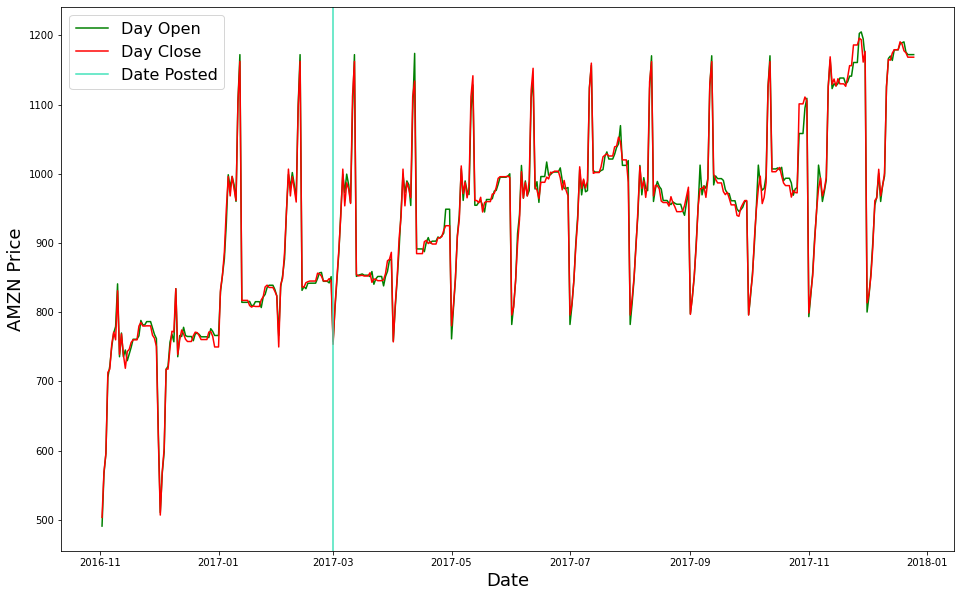

In [ ]:
getGraph('AMZN' , '03-01-2017' , 120,  300) 

En el primer tweet, (Amazon,pesimista) podemos observar que la predicción es erronea. 




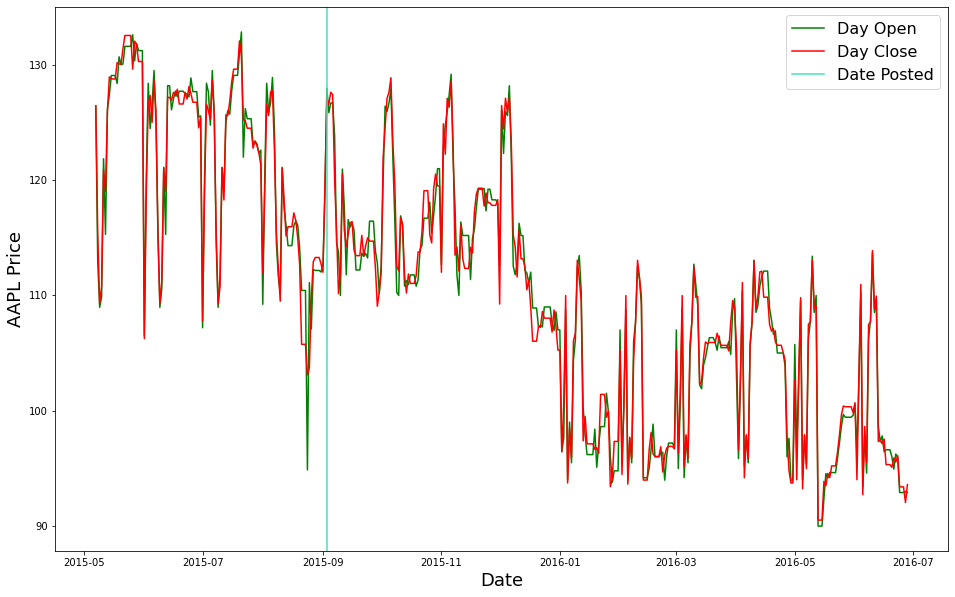

In [ ]:
getGraph('AAPL' , '09-03-2015' , 120,  300) 

Frente a un tweet positivo, podemos observar que el mercado ha sido bajista, por lo cual, podemos darlo como erroneo.

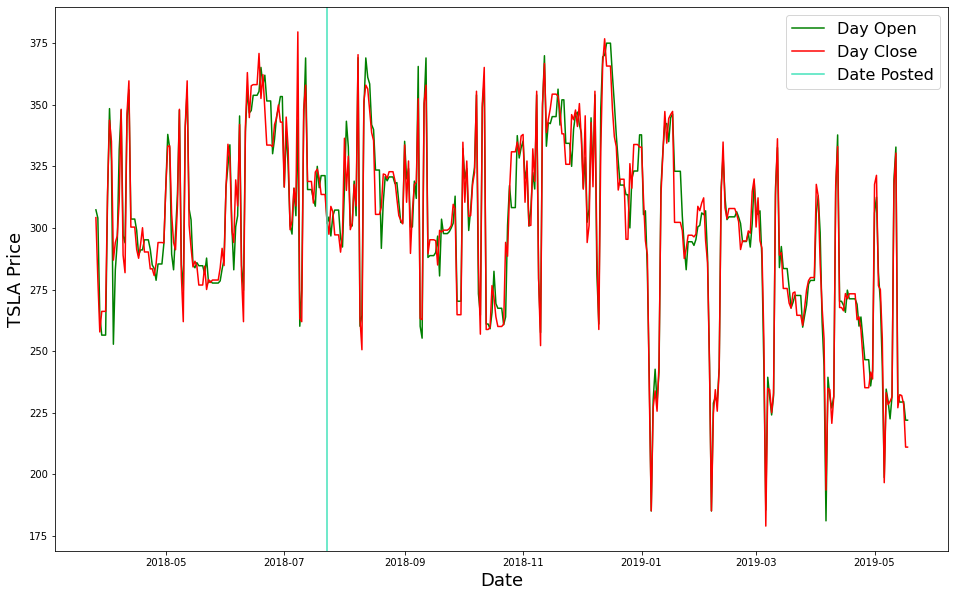

In [ ]:
getGraph('TSLA' , '23-07-2018' , 120,  300) 

Frente a un tweet negativo, podemos observar como el mercado inicia una temporada bajista, por lo cual lo asumiremos como TP.

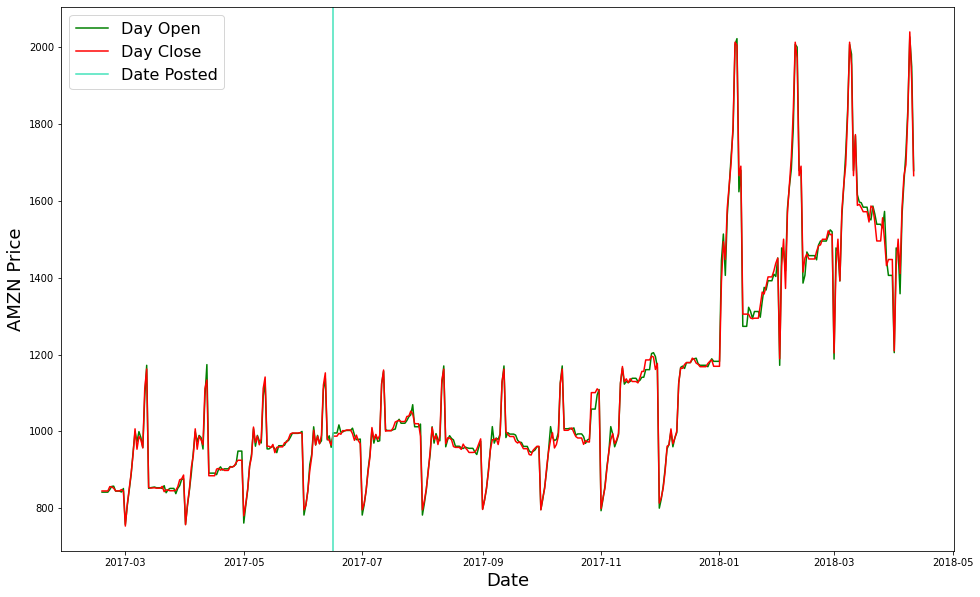

In [ ]:
getGraph('AMZN' , '16-06-2017' , 120,  300)

Frente a un comentario negativo, el mercado inició una subida

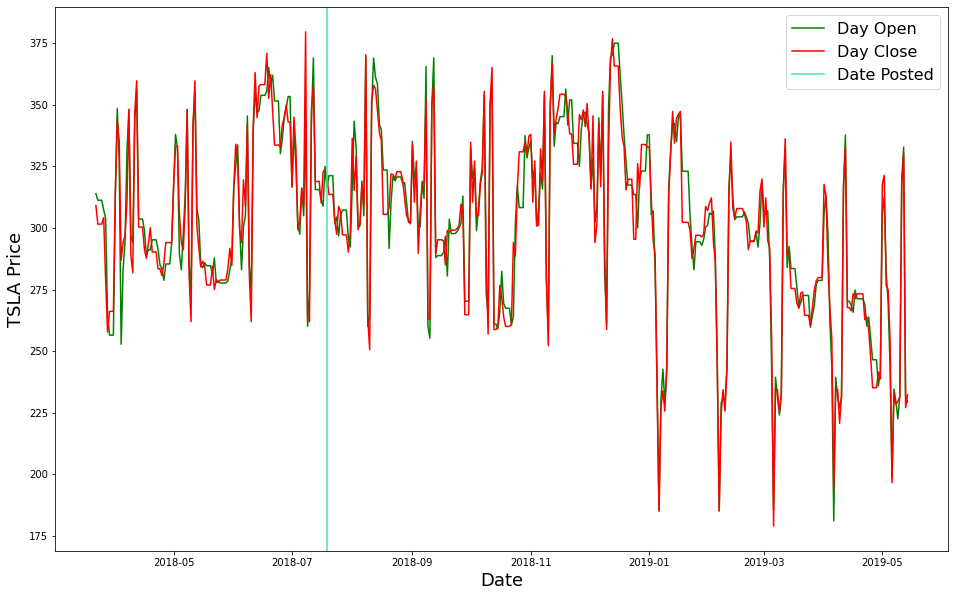

In [ ]:
getGraph('TSLA' , '19-07-2018' , 120,300)

Comentario negativo y bajada del mercado

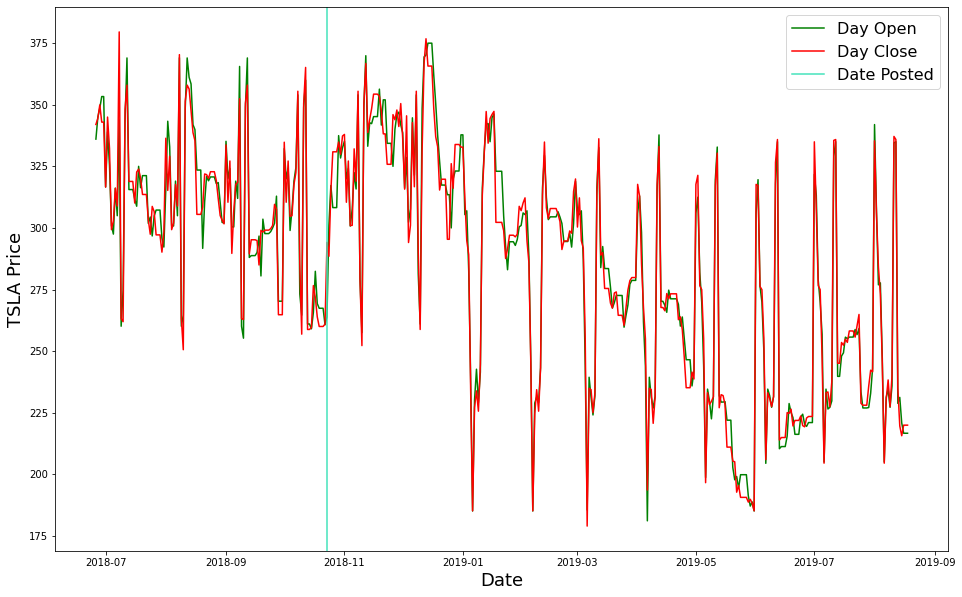

In [ ]:
getGraph('TSLA','23-10-2018',120,300)

Otro comentario negativo, en el cual el mercado también se muestra pesimista

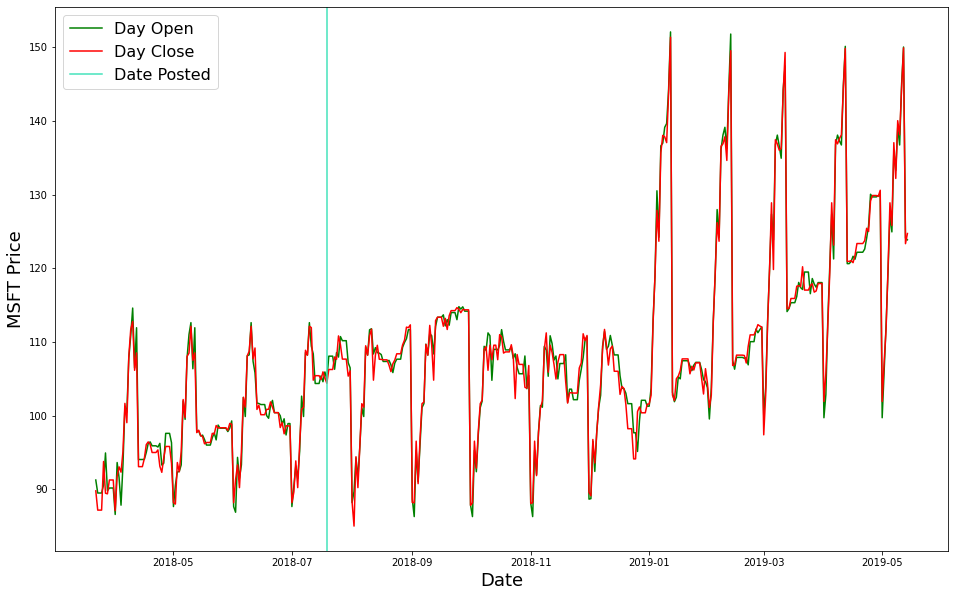

In [ ]:
getGraph('MSFT','19-07-2018',120,300)

Frente a un comentario negativo, el mercado se muestra alcista

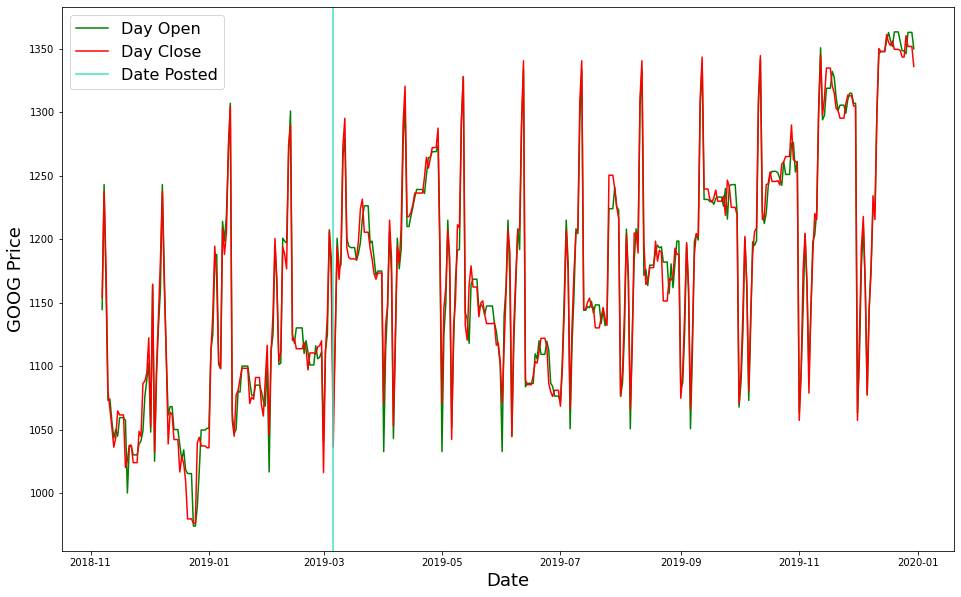

In [ ]:
getGraph('GOOG','03-06-2019',120,300)

Tweet negativo y subida del mercado

Tras estos 8 experimentos, podemos observar como la relación entre los sentimientos de twitter y la bolsa está totalmente desvinculada al estar relacionados en <=50% de las veces, por lo cual, el método es indiferente para predecir, almenos a corto plazo, las tendencias de la bolsa.